# *(Brette, et, al., 2007)* COBA

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

Authors:

- Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp
import brainmodels

## Parameters

In [2]:
# Parameters
num_exc = 3200
num_inh = 800
taum = 20
taue = 5
taui = 10
Vt = -50
Vr = -60
El = -60
Erev_exc = 0.
Erev_inh = -80.
Ib = 20.
we = 0.6  # excitatory synaptic weight (voltage)
wi = 6.7  # inhibitory synaptic weight
ref = 5.0

## Implementation 2

In [7]:
class LIF(bp.NeuGroup):
  target_backend = 'numpy'

  def __init__(self, size, **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    self.V = bp.math.Variable(bp.math.ones(size) * Vr)
    self.Isyn = bp.math.Variable(bp.math.zeros(size))
    self.t_spike = bp.math.Variable(-1e7 * bp.math.ones(size))
    self.spike = bp.math.Variable(bp.math.zeros(size, dtype=bool))

    self.integral = bp.odeint(self.derivative)

  def derivative(self, V, t, Isyn):
    return (Isyn + (El - V) + Ib) / taum

  def update(self, _t, _dt):
    for i in range(self.num):
      self.spike[i] = 0.
      if (_t - self.t_spike[i]) > ref:
        V = self.integral(self.V[i], _t, self.Isyn[i])
        self.spike[i] = 0.
        if V >= Vt:
          self.V[i] = Vr
          self.spike[i] = 1.
          self.t_spike[i] = _t
        else:
          self.V[i] = V
    self.Isyn[:] = 0.

In [8]:
class Syn(bp.TwoEndConn):
  target_backend = 'numpy'

  def __init__(self, pre, post, conn, E, w, tau, **kwargs):
    super(Syn, self).__init__(pre, post, conn=conn, **kwargs)

    # parameters
    self.E = E
    self.w = w
    self.tau = tau

    self.pre2post = self.conn.requires('pre2post')  # connections
    self.g = bp.math.Variable(bp.math.zeros(post.num))  # variables

    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    for pre_id in range(self.pre.num):
      if self.pre.spike[pre_id]:
        post_ids = self.pre2post[pre_id]
        for i in post_ids:
          self.g[i] += self.w
    self.post.Isyn += self.g * (self.E - self.post.V)

In [9]:
E = LIF(num_exc, monitors=['spike'])
I = LIF(num_inh)
E.V[:] = bp.math.random.randn(num_exc) * 5. - 55.
I.V[:] = bp.math.random.randn(num_inh) * 5. - 55.

In [10]:
E2E = Syn(pre=E, post=E, conn=bp.connect.FixedProb(prob=0.02),
          E=Erev_exc, w=we, tau=taue)
E2I = Syn(pre=E, post=I, conn=bp.connect.FixedProb(prob=0.02),
          E=Erev_exc, w=we, tau=taue)
I2E = Syn(pre=I, post=E, conn=bp.connect.FixedProb(prob=0.02),
          E=Erev_inh, w=wi, tau=taui)
I2I = Syn(pre=I, post=I, conn=bp.connect.FixedProb(prob=0.02),
          E=Erev_inh, w=wi, tau=taui)
net = bp.Network(E, I, E2E, E2I, I2I, I2E)
net = bp.math.jit(net)

Compilation used 4.9356 s.
Start running ...
Run 10.0% used 0.009 s.
Run 20.0% used 0.014 s.
Run 30.0% used 0.020 s.
Run 40.0% used 0.026 s.
Run 50.0% used 0.032 s.
Run 60.0% used 0.038 s.
Run 70.0% used 0.044 s.
Run 80.0% used 0.050 s.
Run 90.0% used 0.056 s.
Run 100.0% used 0.061 s.
Simulation is done in 0.062 s.



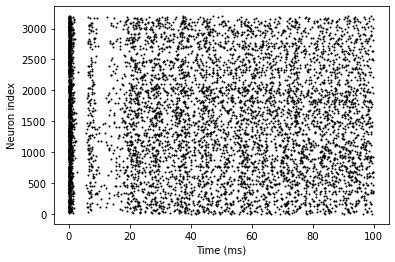

In [11]:
net.run(100., report=0.1)
bp.visualize.raster_plot(E.mon.ts, E.mon.spike, show=True)